# Cheat sheet on do-calculus
R notebook with NoobQuant dev conda environment R installation. Before running make sure .libPaths() contains only one, correct library path.

Dagitty installed to dev conda environment via

```install.packages("dagitty", dependencies = T)```

Useful links:
 - https://cran.r-project.org/web/packages/dagitty/vignettes/dagitty4semusers.html
 - http://www.dagitty.net/manual-3.x.pdf
 - https://cran.r-project.org/web/packages/dagitty/dagitty.pdf


In [2]:
#.libPaths(.libPaths()[2])
#.libPaths()

In [3]:
library(dagitty)

Warning message:
"package 'dagitty' was built under R version 3.6.3"

## Pearl's three rules

From *Book of Why* page 234-235.

**Rule 1**
Observing variable $W$ that is irrelevant to $Y$ (possibly conditionally o other set of variables $Z$) does not change probability distribution of $Y$.

\begin{align}
P(Y | do(X), \ Z, \ W) & = P(Y | do(X), \ Z)
\end{align}

**Rule 2**
If a set of variables $Z$ blocks all back-door paths from $X$ to $Y$, the conditional on $Z$, $do(X)$ is equivalent to $see(X)$.

\begin{align}
P(Y | do(X), \ Z) & = P(Y | X, \ Z)
\end{align}

**Rule 3**
If ther are no causal paths from $X$ to $Y$ (i.e. no paths from $X$ to $Y$ with only forward-directed arrows) then $do(X)$ has no effect on the probability distribution of $Y$. 

\begin{align}
P(Y | do(X)) & = P(Y)
\end{align}

## Example from *The Book of Why* Figure 7.4

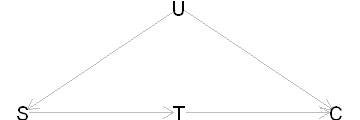

In [11]:
options(repr.plot.width=3, repr.plot.height=1)
g1 = dagitty( 'dag {
    U [latent, pos="1,0"]
    S [exposure, pos="0,1"]
    T [pos="1,1"]
    C [outcome, pos="2,1"]        

    S <- U -> C
    S -> T -> C
}')
plot(g1)

In this example, front-door criterion may be used. Below is the equicalent result due to do-calculus:

$
\begin{align}
P(c \ | \ do(s)) & = \sum_t P(c \ | \ do(s), \ t) \ P(t \ | \ do(s)) \quad & \text{Laf of total probability} \\
& = \sum_t P(c \ | \ do(s), \ do(t)) \ P(t \ | \ do(s)) \quad & do(s) \text{ blocks back-door path -> Rule 2} \\
& = \sum_t P(c \ | \ do(s), \ do(t)) \ P(t \ | \ s) \quad & scsc \\
& = \sum_t P(c \ | \ do(t)) \ P(t \ | \ s) \quad & scsc \\
& = \sum_{s'} \sum_t P(c \ | \ do(t), \ s') \ P(s' \ | \ do(t)) \ P(t \ | \ s) \quad & scsc \\
& = \sum_{s'} \sum_t P(c \ | \ t, \ s') \ P(s' \ | \ do(t)) \ P(t \ | \ s) \quad & scsc \\
& = \sum_{s'} \sum_t P(c \ | \ t, \ s') \ P(s') \ P(t \ | \ s) \quad & scsc \\
\end{align}
$

In [10]:
# Returns empty, as U is latent and there are no adjustment sets
adjustmentSets(g1, type = c("minimal","canonical", "all"), effect = c("total", "direct"))